<a href="https://colab.research.google.com/github/NinaNikolova/data_mining_project/blob/main/python_games_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mодел за прогнозиране на рейтинги на видео игри
## Mодел за логистична регресия - 2, който предсказва рейтинги на видео игри

In [94]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving video_game_reviews.csv to video_game_reviews (7).csv


Импортиране на библиотеки
pandas и numpy - за работа с данни и числови операции
matplotlib и seaborn - за визуализация на данните
sklearn библиотеки - за създаване на модела за машинно обучение, предварителна обработка на данните и оценка на резултатите

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import joblib
import warnings
warnings.filterwarnings('ignore')

Зареждане на данните
Зареждаме данните от CSV файл в променлива df (DataFrame). Тези данни съдържат информация за видео игри и техните рейтинги.
Използва се Video Game Reviews and Ratings dataset:
https://www.kaggle.com/datasets/jahnavipaliwal/video-game-reviews-and-ratings

In [96]:
df = pd.read_csv('/content/video_game_reviews.csv')
df.head()

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1


In [97]:
df["User Review Text"].unique()

array(['Solid game, but too many bugs.',
       'Great game, but the graphics could be better.',
       'Solid game, but the graphics could be better.',
       'Great game, but too many bugs.',
       'Solid game, but the gameplay is amazing.',
       'Disappointing game, but the gameplay is amazing.',
       'Great game, but the gameplay is amazing.',
       'Amazing game, but the gameplay is amazing.',
       'Disappointing game, but the graphics could be better.',
       'Amazing game, but too many bugs.',
       'Amazing game, but the graphics could be better.',
       'Disappointing game, but too many bugs.'], dtype=object)

In [98]:
df.loc[df["User Review Text"].str.contains("bugs", case=False, na=False), "User Review Text"] = "bugs"
df.loc[df["User Review Text"].str.contains("gameplay is amazing", case=False, na=False), "User Review Text"] = "amazing gameplay"
df.loc[df["User Review Text"].str.contains("the graphics could be better", case=False, na=False), "User Review Text"] = "bad graphics"

In [99]:
df["User Review Text"].unique()

array(['bugs', 'bad graphics', 'amazing gameplay'], dtype=object)

In [100]:
df["Graphics Quality"].unique()

array(['Medium', 'Low', 'High', 'Ultra'], dtype=object)

In [101]:
df["Graphics Quality"] = df["Graphics Quality"].replace({
    "High": "good",
    "Ultra": "good",
    "Medium": "bad",
    "Low": "bad"
})

In [102]:
df["Soundtrack Quality"].unique()

array(['Average', 'Poor', 'Good', 'Excellent'], dtype=object)

In [103]:
df["Soundtrack Quality"] = df["Soundtrack Quality"].replace({
   "Good": "good",
    "Excellent": "good",
    "Average": "bad",
    "Poor": "bad"
})

In [104]:
df_target = df["User Rating"]
columns_to_drop = ["User Rating", 'Developer', 'Publisher', 'Game Title', 'Requires Special Device','Age Group Targeted', 'Story Quality', 'Platform']

df= df.drop(columns=columns_to_drop)
df_attributes=pd.get_dummies(df, drop_first=True)

df_attributes.head()


,Price,Release Year,Game Length (Hours),Min Number of Players,Genre_Adventure,Genre_Fighting,Genre_Party,Genre_Puzzle,Genre_RPG,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Multiplayer_Yes,Graphics Quality_good,Soundtrack Quality_good,User Review Text_bad graphics,User Review Text_bugs,Game Mode_Online
0,41.41,2015,55.3,1,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,57.56,2015,34.6,3,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False
2,44.93,2012,13.9,5,True,False,False,False,False,False,False,False,False,True,False,True,True,False,False
3,48.29,2015,41.9,4,False,False,False,False,False,False,False,True,False,False,False,True,True,False,True
4,55.49,2022,13.2,1,False,False,False,False,True,False,False,False,False,True,True,False,False,True,False


Разделяне на данните за обучение и тестване при логистична регресия
Когато работим с логистична регресия и други модели за машинно обучение, е от изключително значение правилно да разделим данните на тренировъчен и тестови набор. Основни стъпки при подготовка на данните: 1.Превръщане на непрекъснатата целева променлива в категорийна - Когато имаме непрекъсната стойност, но искаме да приложим логистична регресия (която работи с класове), трябва първо да трансформираме целевата променлива. В нашия случай използваме медианата като праг 2.Разделяне на данните на тренировъчен и тестови набор 3.Обучение на модела с логистична регресия

In [105]:
df_target_categorical = (df_target > df_target.median()).astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    df_attributes,
    df_target_categorical,
    test_size=0.2,
    random_state=42  # For reproducibility
)
logistic_regression = LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence
logistic_regression.fit(X_train, y_train)



LogisticRegression(max_iter=1000)

Оценка на модела с тестовите данни

In [106]:
# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9502

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4793
           1       0.95      0.95      0.95      4762

    accuracy                           0.95      9555
   macro avg       0.95      0.95      0.95      9555
weighted avg       0.95      0.95      0.95      9555



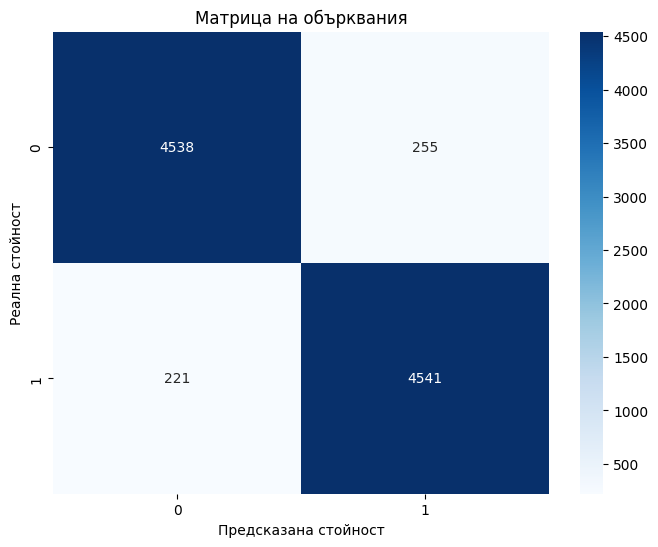

In [107]:
# Визуализация на матрицата на обърквания
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказана стойност')
plt.ylabel('Реална стойност')
plt.title('Матрица на обърквания')
plt.show()


In [108]:
# Анализ на важността на характеристиките
# Извличаме коефициентите от логистичния модел
feature_importance = pd.DataFrame({
    'Характеристика': df_attributes.columns,
    'Коефициент': logistic_regression.coef_[0]  # [0] защото при бинарна класификация има само един набор коефициенти
})
# Изчисляваме абсолютните стойности на коефициентите за сортиране
feature_importance['Абсолютна стойност'] = np.abs(feature_importance['Коефициент'])
# Сортираме по абсолютната стойност в низходящ ред
feature_importance = feature_importance.sort_values('Абсолютна стойност', ascending=False)

# Отпечатваме топ 10 характеристики
print("\nТоп 10 характеристики по важност:")
print(feature_importance.head(10))



Топ 10 характеристики по важност:
                   Характеристика  Коефициент  Абсолютна стойност
0                           Price    0.760293            0.760293
2             Game Length (Hours)    0.456985            0.456985
6                     Genre_Party    0.159839            0.159839
11                   Genre_Sports   -0.077103            0.077103
17          User Review Text_bugs   -0.074475            0.074475
4                 Genre_Adventure    0.073516            0.073516
13                Multiplayer_Yes    0.070678            0.070678
9                   Genre_Shooter   -0.050653            0.050653
5                  Genre_Fighting    0.049347            0.049347
16  User Review Text_bad graphics   -0.046162            0.046162


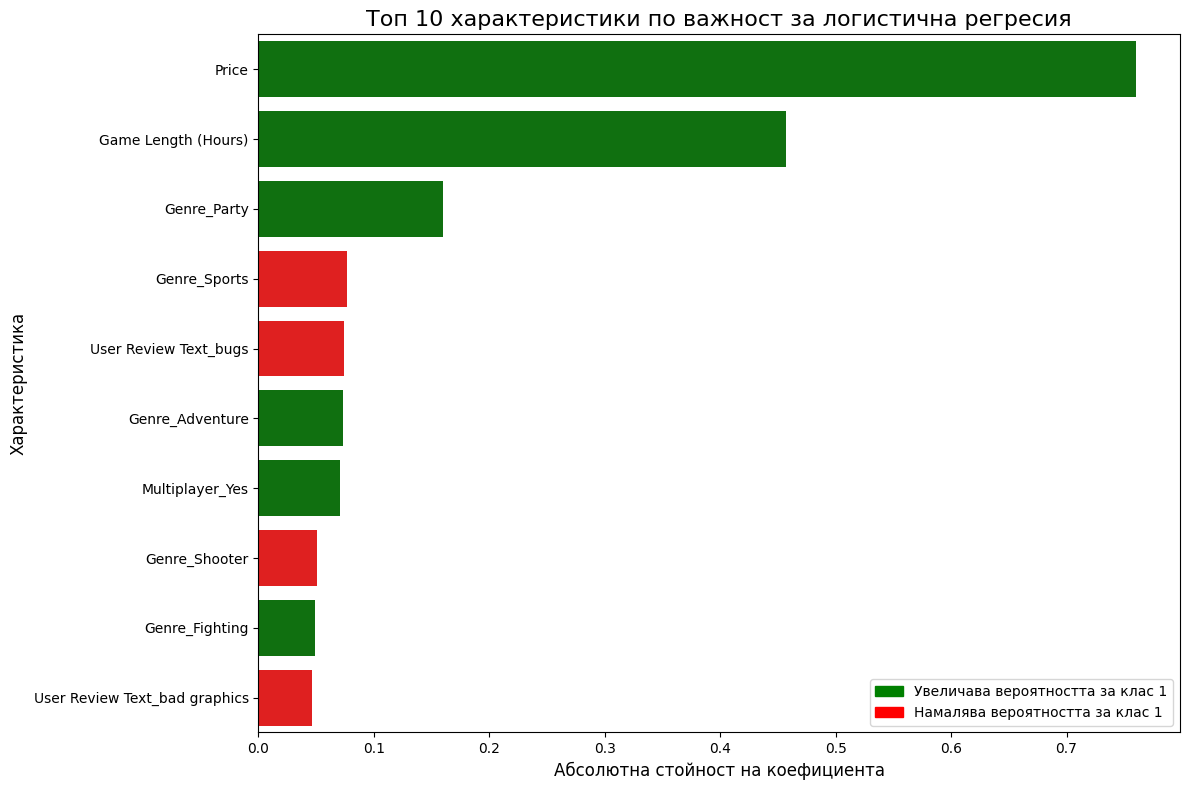

In [109]:
# Стъпка 7: Визуализация на топ 10 характеристики
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
colors = ['green' if x > 0 else 'red' for x in top_features['Коефициент']]

sns.barplot(
    x='Абсолютна стойност',
    y='Характеристика',
    data=top_features,
    palette=colors
)
plt.title('Топ 10 характеристики по важност за логистична регресия', fontsize=16)
plt.xlabel('Абсолютна стойност на коефициента', fontsize=12)
plt.ylabel('Характеристика', fontsize=12)
# Добавяме легенда за положителни и отрицателни коефициенти
import matplotlib.patches as mpatches
pos_patch = mpatches.Patch(color='green', label='Увеличава вероятността за клас 1')
neg_patch = mpatches.Patch(color='red', label='Намалява вероятността за клас 1')
plt.legend(handles=[pos_patch, neg_patch])

plt.tight_layout()
plt.show()